# Loading Dataset

In [1]:
from glob import glob
from keras.utils import np_utils
from sklearn.datasets import load_files
import numpy as np


def load_dataset(path):
    data = load_files(path)
    bones_files = np.array(data['filenames'])
    bones_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return bones_files, bones_targets


names = [item[20:-1] for item in sorted(glob("images/bones/train/*/"))]
train_files, train_targets = load_dataset('images/bones/train')
valid_files, valid_targets = load_dataset('images/bones/valid')
test_files, test_targets = load_dataset('images/bones/test')

print('There are %d total bone disease categories.' % len(names))
print('There are %s total bone images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training bone images.' % len(train_files))
print('There are %d validation bone images.' % len(valid_files))
print('There are %d test bone images.'% len(test_files))


Using TensorFlow backend.


There are 3 total bone disease categories.
There are 304 total bone images.

There are 256 training bone images.
There are 24 validation bone images.
There are 24 test bone images.


# Loading Tensors

In [2]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


# Pre-processing Images

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 24/24 [00:00<00:00, 191.62it/s]


# Creating CNN Model

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(3, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

# Training The Model

In [5]:
from keras.callbacks import ModelCheckpoint

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5',
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 256 samples, validate on 24 samples
Epoch 1/10
256/256 [==============================] - 7s - loss: 1.1454 - acc: 0.3203 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/10
256/256 [==============================] - 7s - loss: 1.0988 - acc: 0.3125 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/10
256/256 [==============================] - 7s - loss: 1.0988 - acc: 0.3320 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/10
256/256 [==============================] - 7s - loss: 1.0987 - acc: 0.3008 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/10
256/256 [==============================] - 7s - loss: 1.0987 - acc: 0.3086 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/10
256/256 [==============================] - 7s - loss: 1.0988 - acc: 0.3320 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/10
256/256 [==============================] - 7s - loss: 1.0987 - acc: 0.3320 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/10
256/256 [==============================] - 7s - loss: 1.0987 - acc: 0.3086 - val_lo

# Testing The Model

In [6]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

bone_diseases_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(bone_diseases_predictions)==np.argmax(test_targets, axis=1))/len(bone_diseases_predictions)
print('Bones test accuracy: %.4f%%' % test_accuracy)


Bones test accuracy: 33.3333%


# Prediction Machine

In [7]:

categories = {
    0: 'Fracture',
    1: 'Osteomyelitis',
    2: 'Osteochondroma'
}

def prediction_machine(img_path):
    tensor = path_to_tensor(img_path)

    prediction_array = model.predict(tensor)
    print(prediction_array)
    prediction = np.argmax(prediction_array)
    return categories[prediction]


# Bone Disease Diagnose

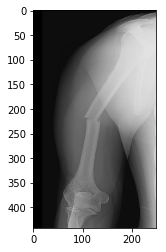

images/bones/final/humerus/humerus_00002.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


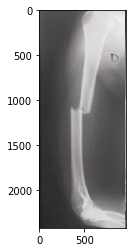

images/bones/final/humerus/humerus_00007.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


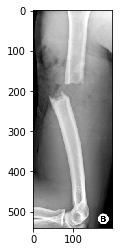

images/bones/final/humerus/humerus_00009.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


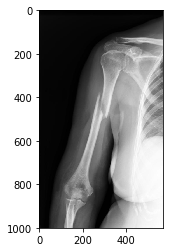

images/bones/final/humerus/humerus_00001.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


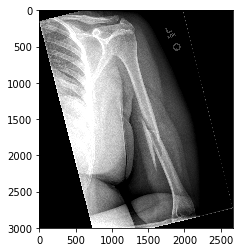

images/bones/final/humerus/humerus_00010.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


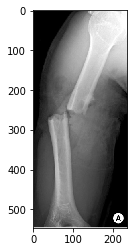

images/bones/final/humerus/humerus_00008.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


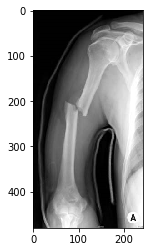

images/bones/final/humerus/humerus_00005.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


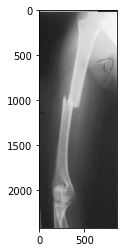

images/bones/final/humerus/humerus_00006.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


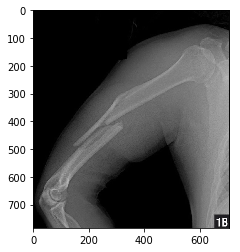

images/bones/final/humerus/humerus_00003.jpeg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


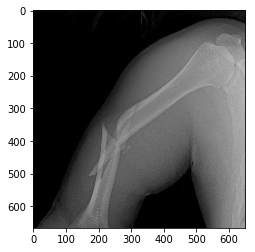

images/bones/final/humerus/humerus_00004.jpg
[[ 0.33443749  0.33261234  0.33295017]]
Predicted Disease: Fracture


In [8]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


final_images = np.array(glob('images/bones/final/humerus/*'))

for img_path in final_images:
    p_img = cv2.imread(img_path)
    p_img_gray = cv2.cvtColor(p_img, cv2.COLOR_BGR2GRAY)
    plt.imshow(p_img)
    plt.show()
    print(img_path)
    prediction = prediction_machine(img_path)
    print('Predicted Disease: {0}'.format(prediction))


# Using Transfer Learning

# ResNet50

In [10]:
# bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
# bf_train = bottleneck_features['train']
# bf_valid = bottleneck_features['valid']
# bf_test = bottleneck_features['test']
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
from keras.models import Sequential, Model

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

x = base_model.output
x = GlobalAveragePooling2D()(x)
transfered_model = Dense(3, activation='softmax')(x)
# transfered_model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# transfered_model.summary()

transfered_model = Model(input=base_model.input, output=transfered_model)

transfered_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



/home/aind2/anaconda3/envs/ai23d/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


# Compiling Transfered Model

In [11]:

transfered_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



# Training Transfered Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5',
                               verbose=1, save_best_only=True)

transfered_model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 256 samples, validate on 24 samples
Epoch 1/20
256/256 [==============================] - 321s - loss: 2.5899 - acc: 0.3984 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/20
256/256 [==============================] - 309s - loss: 1.5524 - acc: 0.5547 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 3/20
256/256 [==============================] - 309s - loss: 1.9290 - acc: 0.5117 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 4/20
256/256 [==============================] - 310s - loss: 1.1711 - acc: 0.6250 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 5/20
256/256 [==============================] - 309s - loss: 1.2753 - acc: 0.5664 - val_loss: 1.0988 - val_acc: 0.3333
Epoch 6/20
 20/256 [=>............................] - ETA: 276s - loss: 1.2301 - acc: 0.7500